In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Churn_Prediction") \
    .config("spark.master", "yarn") \
    .config("spark.executor.memory", "2g") \
    .config("spark.driver.memory", "2g") \
    .config("spark.executor.cores", "2") \
    .config("spark.dynamicAllocation.enabled", "false") \
    .getOrCreate()

25/03/28 18:36:04 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [2]:
# Define HDFS paths
datasets = {
    "telco": "hdfs://master:9000/churn_data/Telco_customer_churn.csv",
    "orange": "hdfs://master:9000/churn_data/churn-bigml-80.csv",
    "iranian": "hdfs://master:9000/churn_data/Customer_Churn.csv"
}

# Load datasets
df_telco = spark.read.csv(datasets["telco"], header=True, inferSchema=True)
df_orange = spark.read.csv(datasets["orange"], header=True, inferSchema=True)
df_iranian = spark.read.csv(datasets["iranian"], header=True, inferSchema=True)

In [3]:
from pyspark.sql.functions import col, when

# Convert Telco Churn (Yes/No → 1/0)
df_telco = df_telco.withColumnRenamed("Churn Label", "Churn")
df_telco = df_telco.withColumn("Churn", when(col("Churn") == "Yes", 1).otherwise(0))

# Convert Orange Churn (True/False → 1/0)
df_orange = df_orange.withColumn("Churn", when(col("Churn") == "TRUE", 1).otherwise(0))

# Iranian dataset already has Churn as 0/1 (No change needed)

# Verify results
df_telco.select("Churn").distinct().show()
df_orange.select("Churn").distinct().show()
df_iranian.select("Churn").distinct().show()

+-----+
|Churn|
+-----+
|    1|
|    0|
+-----+



+-----+
|Churn|
+-----+
|    1|
|    0|
+-----+



[Stage 12:>                                                         (0 + 1) / 1]

+-----+
|Churn|
+-----+
|    1|
|    0|
+-----+



In [4]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler

def preprocess_data(df):
    # Identify categorical columns
    categorical_cols = [c for c, dtype in df.dtypes if dtype == "string" and c != "Churn"]

    # StringIndexer for categorical columns
    indexers = [StringIndexer(inputCol=c, outputCol=c+"_indexed", handleInvalid="keep") for c in categorical_cols]
    for indexer in indexers:
        df = indexer.fit(df).transform(df)

    # Drop original categorical columns
    df = df.drop(*categorical_cols)

    # Drop old features & scaledFeatures column if it exists
    if "features" in df.columns:
        df = df.drop("features")
    if "scaledFeatures" in df.columns:
        df = df.drop("scaledFeatures")

    # Assemble features
    feature_cols = [c for c in df.columns if c != "Churn"]
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    df = assembler.transform(df)

    # Standardize features
    scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
    df = scaler.fit(df).transform(df)
    
    return df

# Apply preprocessing
df_telco = preprocess_data(df_telco)


25/03/28 18:38:50 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
                                                                                

In [5]:
df_orange = preprocess_data(df_orange)


In [6]:
df_iranian = preprocess_data(df_iranian)

In [7]:
print(df_telco)

DataFrame[Count: int, Zip Code: int, Latitude: double, Longitude: double, Tenure Months: int, Monthly Charges: double, Churn: int, Churn Value: int, Churn Score: int, CLTV: int, CustomerID_indexed: double, Country_indexed: double, State_indexed: double, City_indexed: double, Lat Long_indexed: double, Gender_indexed: double, Senior Citizen_indexed: double, Partner_indexed: double, Dependents_indexed: double, Phone Service_indexed: double, Multiple Lines_indexed: double, Internet Service_indexed: double, Online Security_indexed: double, Online Backup_indexed: double, Device Protection_indexed: double, Tech Support_indexed: double, Streaming TV_indexed: double, Streaming Movies_indexed: double, Contract_indexed: double, Paperless Billing_indexed: double, Payment Method_indexed: double, Total Charges_indexed: double, Churn Reason_indexed: double, features: vector, scaledFeatures: vector]


In [8]:
print(df_iranian)

DataFrame[Call  Failure: int, Complains: int, Subscription  Length: int, Charge  Amount: int, Seconds of Use: int, Frequency of use: int, Frequency of SMS: int, Distinct Called Numbers: int, Age Group: int, Tariff Plan: int, Status: int, Age: int, Customer Value: double, Churn: int, features: vector, scaledFeatures: vector]


In [9]:
df_telco.groupBy("Churn").count().show()
df_orange.groupBy("Churn").count().show()
df_iranian.groupBy("Churn").count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|    1| 1869|
|    0| 5174|
+-----+-----+

+-----+-----+
|Churn|count|
+-----+-----+
|    1|  388|
|    0| 2278|
+-----+-----+

+-----+-----+
|Churn|count|
+-----+-----+
|    1|  495|
|    0| 2655|
+-----+-----+



In [10]:
from imblearn.combine import SMOTEENN
import numpy as np



In [11]:
def apply_smote_enn(df):
    df_pd = df.select("scaledFeatures", "Churn").toPandas()
    
    smote_enn = SMOTEENN()
    X_resampled, y_resampled = smote_enn.fit_resample(
        np.array(df_pd["scaledFeatures"].tolist()), df_pd["Churn"]
    )

    return spark.createDataFrame(zip(X_resampled.tolist(), y_resampled), schema=["features", "Churn"])



In [12]:
df_telco_balanced = apply_smote_enn(df_telco)

In [13]:
df_orange_balanced = apply_smote_enn(df_orange)


In [14]:
df_iranian_balanced = apply_smote_enn(df_iranian)

In [15]:
df_telco_balanced

DataFrame[features: array<double>, Churn: bigint]

In [16]:
df_orange_balanced

DataFrame[features: array<double>, Churn: bigint]

In [17]:
df_telco_balanced.write.mode("overwrite").parquet("hdfs://master:9000/churn_data/telco_balanced")
df_orange_balanced.write.mode("overwrite").parquet("hdfs://master:9000/churn_data/orange_balanced")
df_iranian_balanced.write.mode("overwrite").parquet("hdfs://master:9000/churn_data/iranian_balanced")

25/03/28 18:40:25 WARN TaskSetManager: Stage 114 contains a task of very large size (1487 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

In [18]:
df_telco_balanced = df_telco_balanced.repartition(50)  
df_orange_balanced = df_orange_balanced.repartition(50)
df_iranian_balanced = df_iranian_balanced.repartition(50)

In [20]:
import xgboost as xgb
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
def train_xgboost(df, dataset_name):
    train, test = df.randomSplit([0.8, 0.2])

    # Convert Spark DataFrame to Pandas for XGBoost
    train_pd = train.select("features", "Churn").toPandas()
    test_pd = test.select("features", "Churn").toPandas()

    # Convert features to NumPy array
    X_train = np.array(train_pd["features"].tolist())
    y_train = np.array(train_pd["Churn"])
    X_test = np.array(test_pd["features"].tolist())
    y_test = np.array(test_pd["Churn"])

    # Convert to DMatrix
    train_dmatrix = xgb.DMatrix(X_train, label=y_train)
    test_dmatrix = xgb.DMatrix(X_test, label=y_test)

    # Train XGBoost Model
    params = {"objective": "binary:logistic", "max_depth": 5, "eta": 0.1}
    num_boost_round = 100
    bst = xgb.train(params, train_dmatrix, num_boost_round)

    # Make predictions
    y_proba = bst.predict(test_dmatrix)  # Probabilities
    y_pred = (y_proba >= 0.5).astype(int)  # Convert to binary (0 or 1)

    # Evaluate Model
    evaluate_model(y_test, y_pred, y_proba, dataset_name)
    joblib.dump(bst,f"/home/pavan/Downloads/{dataset_name}")
    # Save Model
    #bst.save_model(f"{dataset_name}_churn_model.json")

def evaluate_model(y_true, y_pred, y_proba, dataset_name):
    """Evaluate model performance using classification metrics and plots."""
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Compute Metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba)

    print(f"Evaluation Metrics for {dataset_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}\n")

    # Confusion Matrix Visualization
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Churn', 'Churn'], yticklabels=['Non-Churn', 'Churn'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {dataset_name}')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {dataset_name}")
    plt.legend()
    plt.show()



25/03/28 18:45:39 WARN TaskSetManager: Stage 135 contains a task of very large size (1487 KiB). The maximum recommended task size is 1000 KiB.
25/03/28 18:45:41 WARN TaskSetManager: Stage 138 contains a task of very large size (1487 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

Evaluation Metrics for telco:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
AUC: 1.0000



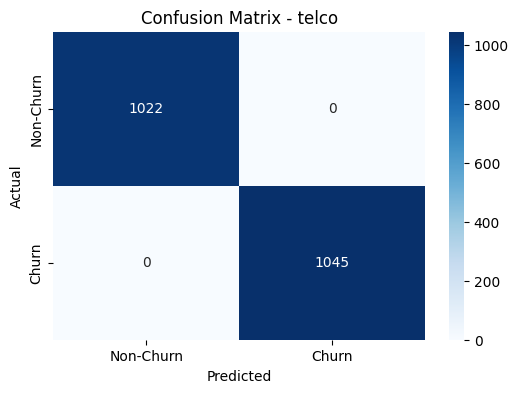

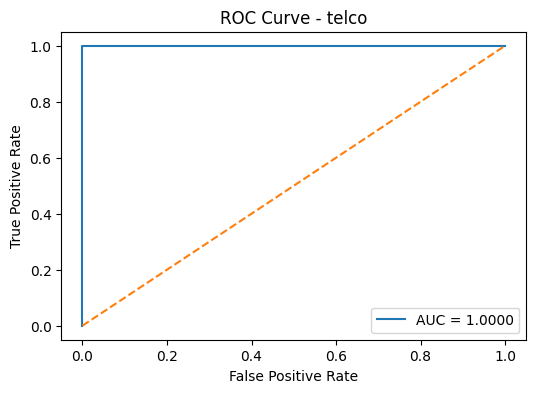

In [21]:
train_xgboost(df_telco_balanced, "telco")


Evaluation Metrics for orange:
Accuracy: 0.9678
Precision: 0.9649
Recall: 0.9786
F1 Score: 0.9717
AUC: 0.9894



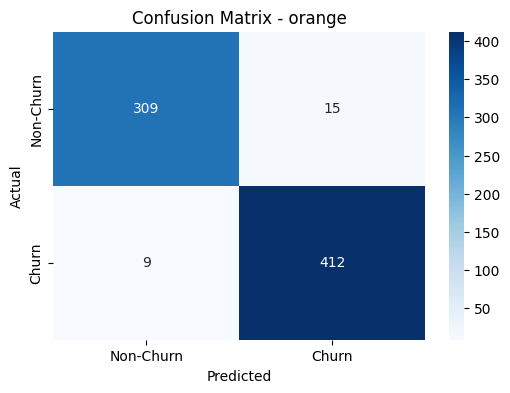

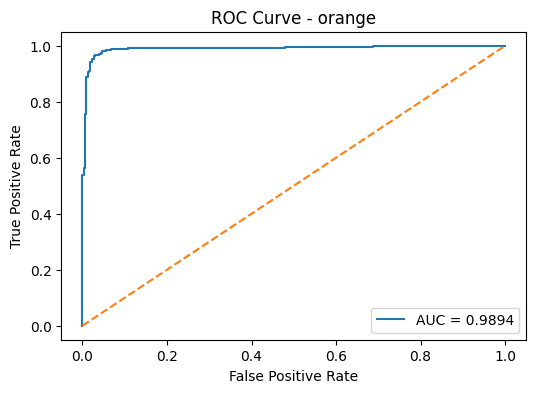

In [22]:
train_xgboost(df_orange_balanced, "orange")

Evaluation Metrics for iranian:
Accuracy: 0.9892
Precision: 0.9867
Recall: 0.9924
F1 Score: 0.9895
AUC: 0.9988



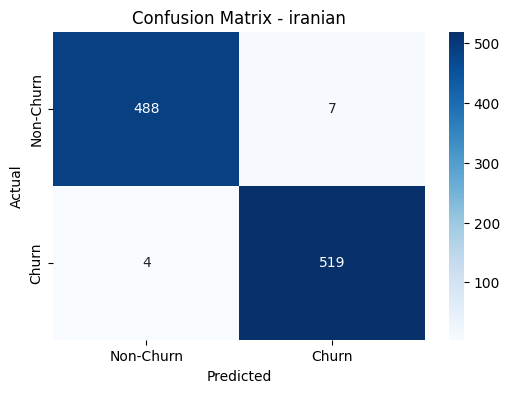

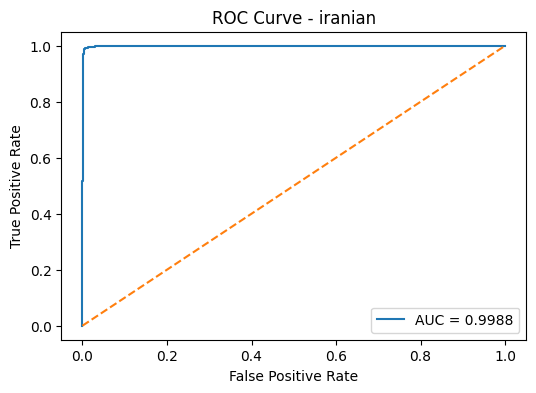

In [23]:
train_xgboost(df_iranian_balanced, "iranian")

In [24]:
print("Telco Balanced Count:", df_telco_balanced.count())
print("Orange Balanced Count:", df_orange_balanced.count())
print("Iranian Balanced Count:", df_iranian_balanced.count())

25/03/28 18:46:45 WARN TaskSetManager: Stage 153 contains a task of very large size (1487 KiB). The maximum recommended task size is 1000 KiB.


Telco Balanced Count: 10319


Orange Balanced Count: 3843


[Stage 167:================================================>      (44 + 2) / 50]

Iranian Balanced Count: 4925
